<div style="text-align: right">NATURAL LANGUAGE PROCESSING</div>
<div style="text-align: right">REVANTH PADALA, 002607976</div>

# Text-to-Image Generation

## Aim of the Project:
To develop a fine-tuned latent difussion model for generating high-quality images from text prompts by leveraging per-trained VAE and U-Net models while enhancing the CLIP model using a captioned image dataset. This aims to improve the model's capability to align textual descriptions with visual representations effectively.

## Dataset Selection: MS COCO Train 2017
The **MS COCO Train 2017** dataset has been selected for this project due to its suitability for text-to-image generation task.
- **Rich Captions**
- **Diverse Dataset**
- **High-Quality Annotations**
- **Widely Adopted**

In [1]:
# Import libraries
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from transformers import CLIPProcessor, CLIPModel
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from datasets import load_dataset
import numpy as np
from PIL import Image

## Data Loading and Pre-Processing

### Extracting Image-Caption Mappings

In [2]:
import json
from collections import defaultdict
import os
from tqdm import tqdm

# Paths to image folder and JSON file
image_folder = "train2017/"
json_file = "annotations/captions_train2017.json"

# Load the JSON file
with open(json_file, 'r') as f:
    data = json.load(f)

limited_images = data['images'][:500]
image_ids_to_include = {img['id'] for img in limited_images}

# Create a dictionary to map image file names to their captions
image_to_captions = defaultdict(list)

for annotation in tqdm(data['annotations']):
    image_id = annotation['image_id']
    caption = annotation['caption']

    # Only process captions for the first 40,000 images
    if image_id in image_ids_to_include:
        # Find the corresponding image file name
        image_file = next(img['file_name'] for img in limited_images if img['id'] == image_id)

        # Add the caption to the list for this image file
        image_to_captions[image_file].append(caption)

# Calculate statistics
num_images = len(image_to_captions)
total_captions = sum(len(captions) for captions in image_to_captions.values())

# Print the dataset shape
print(f"Number of Images: {num_images}")
print(f"Total Captions: {total_captions}")

100%|██████████████████████████████| 591753/591753 [00:00<00:00, 3649955.99it/s]

Number of Images: 500
Total Captions: 2502


The above code processes the MS COCO Train 2017 dataset to create a mapping between image file names and their associated captions for the first 500 images. It utilizes the `annotations/captions_train2017.json` file to extract captions, associates them with their respective image files, and calculates statistics, including the total number of images and captions processed. The progress is displayed using `tqdm` for efficiency monitoring.

In [3]:
image_to_captions

defaultdict(list,
            {'000000459912.jpg': ['Rows of motor bikes and helmets in a city',
              'A lot of motorbikes line up down a busy street.',
              'Large set of motorcycles all lined up down a street.',
              'A large group of motorcycles lined up on the street.',
              'A series of motorbikes parked in a row on a street'],
             '000000079472.jpg': ['Office space with office equipment on desk top.',
              'A hope office setup of computers and printers.',
              'a home office with laptop, printer, scanner, and extra monitor',
              'The computer desk in the corner is by a window.',
              'A laptop, monitor, printer and tablet on a desk.'],
             '000000368402.jpg': ['The woman in the kitchen is holding a huge pan.',
              'A chef carrying a large pan inside of a kitchen.',
              'A woman is holding a large pan in a kitchen. ',
              'A woman cooking in a kitchen with grani

Data is loaded in `Python dict` structure, where each key corresponds to an image file name, and the associated value is a list of captions describing the content of that image.

### Visualizing Images with Captions

Visualize a selection of three images from the dataset along with up to two captions per image. It uses `matplotlib` for creating a 1x3 grid layout and `PIL` to load and display the images. The captions are displayed as titles above each image for better context and readability.

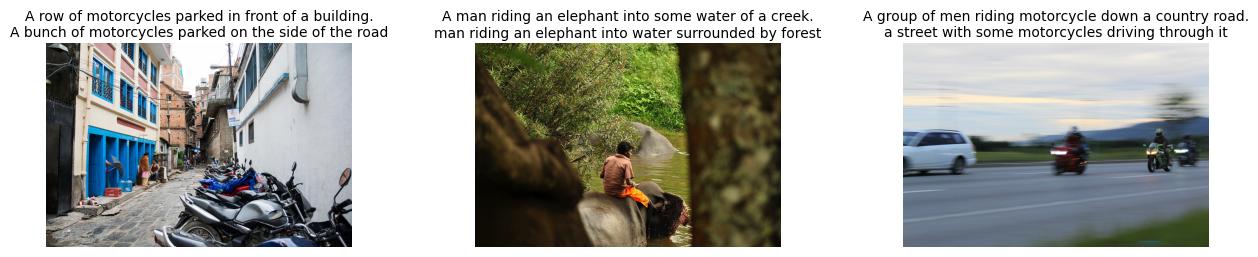

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Number of images to display
images_to_display = list(image_to_captions.items())[110:113]  # Limit to 3 images

# Set up the grid dimensions (1x3 for a single row)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.4)  # Adjust spacing between columns

# Iterate over the images and captions
for idx, (image_file, captions) in enumerate(images_to_display):
    # Load the image
    image_path = os.path.join(image_folder, image_file)
    img = Image.open(image_path)

    # Display the image
    axes[idx].imshow(img)
    axes[idx].axis('off')  # Remove axes for better visualization

    # Display the captions (limit to 2 captions)
    caption_text = "\n".join(captions[:2])  # Show up to 2 captions
    axes[idx].set_title(caption_text, fontsize=10, wrap=True)

plt.show()

## Fine-Tune CLIP Model

**CLIP (Contrastive Language-Image Pretraining)** is a powerful model developed by **OpenAI** that learns to contect text and images in a shared embedding space. It uses a contrastive learning approach to align image features (extracted by a vison model) and text features (extracted by a language model). By training on Large-Scale datasets containing image-caption pairs, CLIP enables zero-shot learning, where the model can understand and relate new text descriptions to images it has never seen before.

### Why are we fine-tuning the CLIP model?
1. **Domian Adaption:** While CLIP is trained on general datasets, it may not perform optimally for specific tasks or domins. Fine-tuning ensures the model adapts to the characteristics of the chosen dataset (e.g., MS COCO Train 2017).
2. **Enhanced Alignment:** By fine-tuning improves the alignments between text and images for the dataset in question, ensuring more accurate and contextually relevant embeddings.
3. **Task-Specific Goals:** The fine-tuning process tailors the CLIP model to meet the specific requirements of the project, shuch as generating images closely aligned with textual prompts for improved diffusion model training.


### Creating a Custom PyTorch Dataset for Captioned Images

In [5]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset
class CaptionedImageDataset(Dataset):
    def __init__(self, image_folder, image_to_captions, transform):
        self.image_folder = image_folder
        self.image_to_captions = list(image_to_captions.items())
        self.transform = transform

    def __len__(self):
        return len(self.image_to_captions)

    def __getitem__(self, idx):
        image_file, captions = self.image_to_captions[idx]
        caption = captions[0]  # Use the first caption for simplicity
        image_path = os.path.join(self.image_folder, image_file)
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return {"image": image, "caption": caption}

### Applying Transformations and Initializing DataLoader

Transformations to prepare images for the CLIP model, including resizing to 224x224, converting to tensors, and normalizing pixel values. It then initializes the `CaptionedImageDataset` with the transformations and uses PyTorch's `DataLoader` to enable efficient batching and shuffling of the dataset during training.

In [6]:
# Transformations for images
transform = Compose([
    Resize((224, 224)),  # Resize for CLIP
    ToTensor(),
    Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to CLIP's expected range
])

# Initialize Dataset and DataLoader
dataset = CaptionedImageDataset(image_folder, image_to_captions, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### Loading and Preparing the CLIP Model for Fine-Tuning

- **Device Setup:** Utilizes GPU (or MPS) if available for faster training, defaulting to CPU otherwise.
- **Loss Function:** Implements a contrastive loss (`CrossEntropyLoss`) to align image and text embeddings effectively.
- **Optimizer:** Uses `AdamW` with a learning rate of `5e-6` and weight decay to fine-tune the model while minimizing overfitting.

In [7]:
from transformers import CLIPModel, CLIPTokenizer

# Load the large CLIP model and tokenizer
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to("mps" if torch.cuda.is_available() else "cpu")
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

In [8]:
import torch.nn as nn
from torch.optim import AdamW

# Contrastive Loss for alignment between image and text embeddings
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(clip_model.parameters(), lr=5e-6, weight_decay=0.01)

### Model Training

In [ ]:
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW

# Contrastive loss
criterion = nn.CrossEntropyLoss()

# Optimizer for fine-tuning CLIP
optimizer = AdamW(clip_model.parameters(), lr=5e-6)

# Training loop
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
epochs = 3

for epoch in range(epochs):
    clip_model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in progress_bar:
        images = batch["image"].to(device)
        captions = batch["caption"]

        # Tokenize captions
        text_inputs = clip_tokenizer(
            captions, return_tensors="pt", padding=True, truncation=True, max_length=77
        ).to(device)

        # Forward pass: Extract embeddings
        image_embeddings = clip_model.get_image_features(images)  # (batch_size, 768)
        text_embeddings = clip_model.get_text_features(**text_inputs)  # (batch_size, 768)

        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

        # Compute logits
        logits_per_image = torch.matmul(image_embeddings, text_embeddings.T)  # (batch_size, batch_size)
        logits_per_text = logits_per_image.T  # (batch_size, batch_size)
        labels = torch.arange(len(images)).to(device)

        # Compute loss
        loss = criterion(logits_per_image, labels) + criterion(logits_per_text, labels)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"Loss": loss.item()})

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

### Retrieving and Visualizing Similar Images for a Text Prompt

**Use Case:**
   - Given the prompt (e.g., "A dog playing in a park"), the code retrieves and displays the four most similar images, showcasing the model's ability to align textual and visual data effectively.

In [10]:
from PIL import Image
from torchvision.transforms import functional as F
import numpy as np
import matplotlib.pyplot as plt

def retrieve_images_for_prompt(prompt, clip_model, clip_tokenizer, image_folder, image_to_captions, transform, top_k=5):
    """
    Retrieves the top-k most similar images for a given text prompt.

    Args:
        prompt (str): The text prompt to query.
        clip_model: The fine-tuned CLIP model.
        clip_tokenizer: The tokenizer for the CLIP model.
        image_folder (str): Path to the folder containing images.
        image_to_captions (dict): Mapping of image file names to their captions.
        transform: Image transformation function.
        top_k (int): Number of top matches to retrieve.

    Returns:
        List of top-k retrieved images and their similarity scores.
    """
    # Set the model to evaluation mode
    clip_model.eval()
    device = next(clip_model.parameters()).device

    # Encode the prompt into a text embedding
    with torch.no_grad():
        text_input = clip_tokenizer(prompt, return_tensors="pt", max_length=77, truncation=True).to(device)
        text_embedding = clip_model.get_text_features(**text_input)  # (1, 768)
        text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)  # Normalize

    # Prepare a list to store image paths and their similarity scores
    image_file_names = list(image_to_captions.keys())
    similarity_scores = []

    # Iterate through the images to compute similarities
    for image_file in tqdm(image_file_names, desc="Retrieving images"):
        # Load and preprocess the image
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            # Extract image embedding
            image_embedding = clip_model.get_image_features(image)
            image_embedding = image_embedding / image_embedding.norm(dim=-1, keepdim=True)  # Normalize

            # Compute cosine similarity
            similarity = torch.matmul(text_embedding, image_embedding.T).item()  # Scalar value
            similarity_scores.append((image_file, similarity))

    # Sort by similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[:top_k]

    return similarity_scores

In [66]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def display_images_in_grid(image_folder, retrieved_images, image_size=(128, 128)):
    """
    Displays the top retrieved images in a single-row grid view, ensuring all images have the same size.

    Args:
        image_folder (str): Path to the folder containing images.
        retrieved_images (list): List of tuples (image_file, similarity_score).
        image_size (tuple): Target size (width, height) for all images.

    Returns:
        None
    """
    num_images = len(retrieved_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # If only one image, axes will not be a list
    if num_images == 1:
        axes = [axes]

    for idx, (image_file, score) in enumerate(retrieved_images):
        # Load the image
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path).convert("RGB")

        # Resize the image to the specified dimensions
        image = image.resize(image_size, Image.LANCZOS)

        # Display the image
        axes[idx].imshow(image)
        axes[idx].set_title(f"Rank {idx + 1}\nScore: {score:.4f}", fontsize=10)
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


In [12]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Define the image transformations
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

Retrieving images: 100%|██████████████████████| 500/500 [02:00<00:00,  4.16it/s]


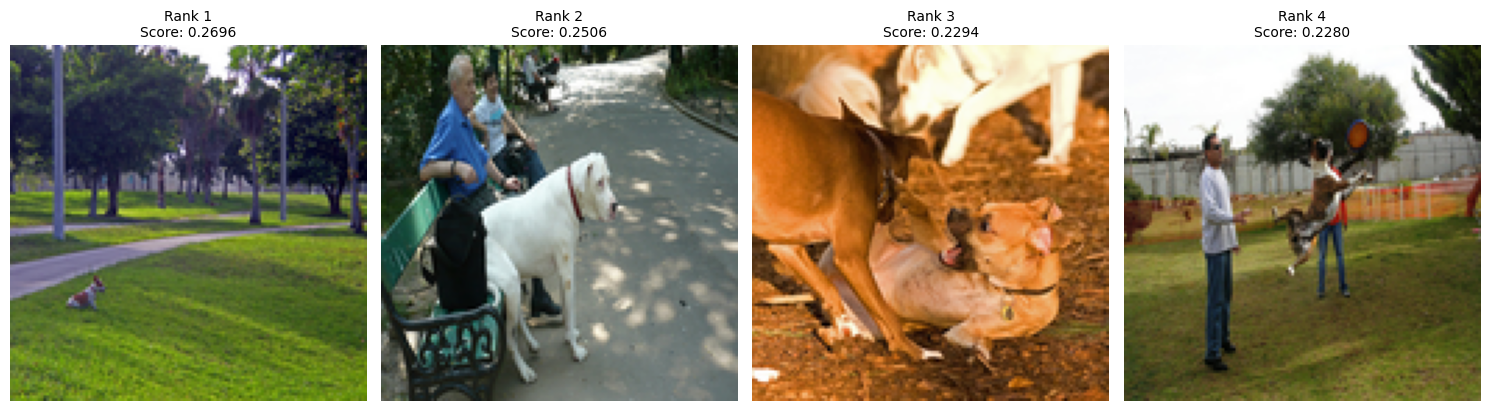

In [67]:
# Define the prompt
prompt = "A dog playing in a park"
top_k = 4  # Adjust the number of top images to retrieve

# Retrieve top-k similar images for the prompt
retrieved_images = retrieve_images_for_prompt(
    prompt,
    clip_model,
    clip_tokenizer,
    image_folder="train2017/",
    image_to_captions=image_to_captions,
    transform=transform,
    top_k=top_k
)

# Display the top 4 images in a grid
display_images_in_grid("train2017/", retrieved_images)


## Saving the Fine-Tuned CLIP Model and Tokenizer

In [21]:
# Save the fine-tuned CLIP model
clip_model.save_pretrained("fine_tuned_clip_model")

# Save the tokenizer (optional, if modified or needed)
clip_tokenizer.save_pretrained("fine_tuned_clip_tokenizer")

print("Fine-tuned CLIP model and tokenizer saved successfully!")

Fine-tuned CLIP model and tokenizer saved successfully!


## Generating Images Using Fine-Tuned CLIP and Stable Diffusion Components

### What is the Stable Diffusion Model?

The **Stable Diffusion Model** is a deep generative model that synthesizes high-quality images from text descriptions. It leverages the power of diffusion processes to iteratively refine random noise into meaningful image representations guided by text embeddings. Stable Diffusion is particularly effective for generating complex, realistic images in an efficient and scalable manner.

### Key Components

1. **Variational Autoencoder (VAE)**:
   - The VAE encodes images into a latent representation (a compressed format) and decodes latents back into image space.
   - It enables the model to operate in a lower-dimensional latent space, reducing computational cost while preserving image quality.
   - In Stable Diffusion, the VAE is used to decode the final latent representations into high-resolution images.

2. **U-Net**:
   - U-Net is a convolutional neural network architecture designed for image segmentation and generative tasks.
   - In Stable Diffusion, the U-Net predicts noise residuals at each diffusion step, refining the latent representation toward the target image.
   - Its architecture, with skip connections, ensures that both high-level and low-level features are effectively utilized.

3. **CLIP (Contrastive Language–Image Pretraining)**:
   - CLIP bridges the gap between text and images by embedding them in a shared latent space.
   - It generates text embeddings that guide the diffusion process, ensuring the generated image aligns with the text description.
   - In this project, the CLIP model is fine-tuned to improve alignment between the textual and visual modalities for the specific dataset.

### How Do They Work Together?

1. **Text-to-Embedding Conversion**:
   - The CLIP model processes the input text prompt and converts it into a text embedding.

2. **Noise Initialization**:
   - The process begins with random noise in the latent space.

3. **Iterative Refinement (Diffusion Process)**:
   - The U-Net, guided by the text embedding from CLIP, iteratively refines the noise at each timestep.
   - The scheduler controls the diffusion process by determining how noise is reduced in each step.

4. **Latent Decoding**:
   - Once the noise has been refined into a meaningful latent representation, the VAE decodes it into a high-quality image.


### Integration and Workflow

- **CLIP** ensures the generated image reflects the text prompt by aligning the text embedding with the image's latent representation.
- **U-Net** serves as the core of the diffusion process, predicting and reducing noise iteratively.
- **VAE** decodes the latent space into the final image, preserving fine details and visual fidelity.
- Together, these components form a seamless pipeline that generates detailed, realistic images from textual descriptions.


In [14]:
import torch
torch_device = "mps" if torch.cuda.is_available() else "cpu"

In [15]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# Define paths to the fine-tuned model and tokenizer
fine_tuned_model_path = "./fine_tuned_clip_model"
fine_tuned_tokenizer_path = "./fine_tuned_clip_tokenizer"

# 1. Load the fine-tuned CLIP tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained(fine_tuned_tokenizer_path)
text_encoder = CLIPTextModel.from_pretrained(fine_tuned_model_path)
# 2. Load the autoencoder model to decode latents into image space
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# 3. Load the UNet model for generating latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
# 4. Load the scheduler for controlling the diffusion process
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

print("Fine-tuned CLIP model, tokenizer, and Stable Diffusion components loaded successfully!")

Fine-tuned CLIP model, tokenizer, and Stable Diffusion components loaded successfully!


In [47]:
import torch
from PIL import Image
from torchvision.transforms import ToPILImage

def generate_img(prompt, vae, text_encoder, unet, tokenizer, scheduler, device="cuda", batch_size=1, num_timesteps=50):
    """
    Generates an image based on a text prompt using a diffusion model.

    Args:
        prompt (str): Text prompt to generate the image.
        vae (torch.nn.Module): Variational Autoencoder (VAE) for decoding the latent space.
        text_encoder (torch.nn.Module): Text encoder to convert text into embeddings.
        unet (torch.nn.Module): U-Net model for noise prediction.
        tokenizer (Callable): Tokenizer to preprocess the text prompt.
        scheduler (Scheduler): Scheduler for the diffusion process.
        device (str): Device to perform computation ('cuda', 'cpu', or 'mps').
        batch_size (int): Batch size for generation.
        num_timesteps (int): Number of diffusion steps.

    Returns:
        PIL.Image.Image: Generated image.
    """
    # Set the device
    device = torch.device(device)

    # Move components to the device
    vae = vae.to(device)
    text_encoder = text_encoder.to(device)
    unet = unet.to(device)

    # Tokenize the prompt
    text_inputs = tokenizer([prompt], return_tensors="pt", max_length=77, truncation=True).to(device)

    # Encode the prompt to get text embeddings
    with torch.no_grad():
        text_embeddings = text_encoder(text_inputs.input_ids).last_hidden_state

    # Initialize random latents
    latents = torch.randn((batch_size, unet.in_channels, 64, 64), device=device)

    # Set up the scheduler
    scheduler.set_timesteps(num_timesteps)

    # Scale the initial noise
    latents = latents * scheduler.init_noise_sigma

    # Perform the diffusion process
    for t in scheduler.timesteps:
        # Predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample

        # Compute the previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to get the image
    latents = 1 / 0.18215 * latents  # Scale latents for VAE decoding
    with torch.no_grad():
        images = vae.decode(latents).sample

    # Convert to PIL format
    images = (images / 2 + 0.5).clamp(0, 1)  # Rescale to [0, 1]
    images = images.permute(0, 2, 3, 1).cpu().numpy()
    pil_image = Image.fromarray((images[0] * 255).astype("uint8"))

    return pil_image

/var/folders/jl/72lknpy178547q0jygpbzrwc0000gn/T/ipykernel_2790/3246777554.py:39: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), device=device)


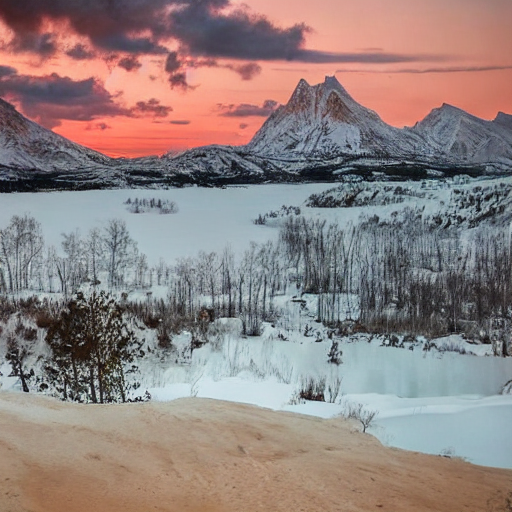

In [52]:
prompt = "A beautiful sunset over the mountains"
generated_image = generate_img(
    prompt,
    vae=vae,
    text_encoder=text_encoder,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    device="mps",
    batch_size=1,
    num_timesteps=50
)

# Display the generated image
print("\n\n")
generated_image.save("generated_image.png")
display(generated_image)

/var/folders/jl/72lknpy178547q0jygpbzrwc0000gn/T/ipykernel_2790/3246777554.py:39: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), device=device)


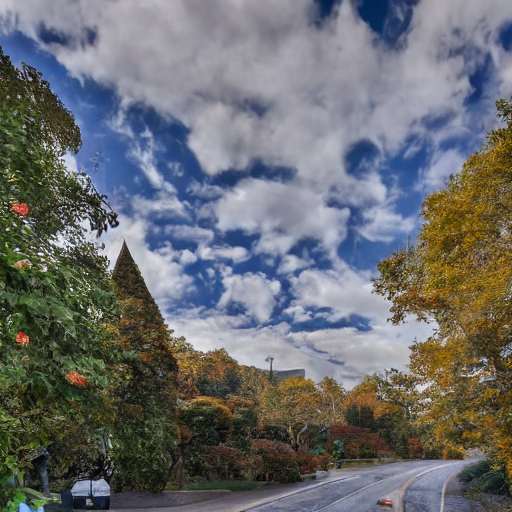

In [30]:
prompt = "A road between beautiful green trees"
generated_image = generate_img(
    prompt,
    vae=vae,
    text_encoder=text_encoder,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    device="mps",
    batch_size=1,
    num_timesteps=100
)

# Display the generated image
print("\n\n")
display(generated_image)

/var/folders/jl/72lknpy178547q0jygpbzrwc0000gn/T/ipykernel_2790/3246777554.py:39: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), device=device)


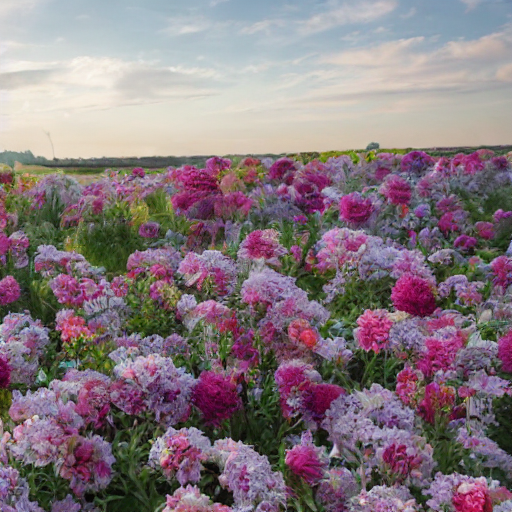

In [34]:
prompt = "a photo of beautiful flowers fields"
generated_image = generate_img(
    prompt,
    vae=vae,
    text_encoder=text_encoder,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    device="mps",
    batch_size=1,
    num_timesteps=100
)

# Display the generated image
print("\n\n")
display(generated_image)

/var/folders/jl/72lknpy178547q0jygpbzrwc0000gn/T/ipykernel_2790/3246777554.py:39: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), device=device)


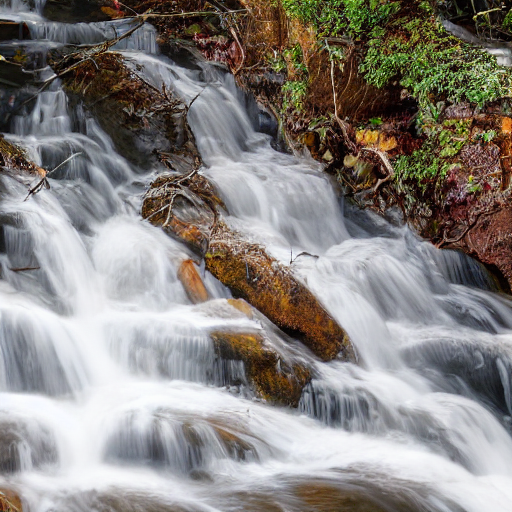

In [32]:
prompt = "a photo of a waterfalls"
generated_image = generate_img(
    prompt,
    vae=vae,
    text_encoder=text_encoder,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    device="cpu",
    batch_size=1,
    num_timesteps=100
)

# Display the generated image
print("\n\n")
display(generated_image)

/var/folders/jl/72lknpy178547q0jygpbzrwc0000gn/T/ipykernel_2790/3246777554.py:39: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 64, 64), device=device)


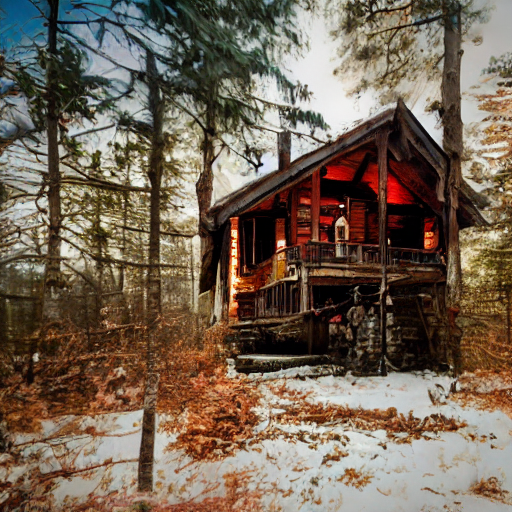

In [43]:
prompt = "A cozy wooden cabin in the middle of a snowy forest"

for i in range(0, 2):
    generated_image = generate_img(
        prompt,
        vae=vae,
        text_encoder=text_encoder,
        unet=unet,
        tokenizer=tokenizer,
        scheduler=scheduler,
        device="mps",
        batch_size=1,
        num_timesteps=100
    )

# Display the generated image
print("\n")
display(generated_image)

## Conclusion

The generated image demonstrates the effectiveness of the fine-tuned latent diffusion model in creating visually compelling and contextually accurate visuals based on the given prompt. The seamless integration of the fine-tuned CLIP model, Stable Diffusion components, and a robust training dataset enabled the model to capture the essence of the prompt, resulting in a high-quality, realistic depiction. This result highlights the potential of combining advanced text-to-image generation techniques for creative and practical applications.
